# Tutoriel Python

* Import des donnees
* Analyse descriptive
* Preparation des donnees
* Creation d’un modele en cross validation
* Calcul des predictions et soumission

# Import des données

Avant de rentrer dans le vif du sujet, importons quelques packages necessaires pour ce tutoriel :

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/anaconda3/envs/conda_py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../data_challenge/boites_medicaments_train.csv',
                    encoding='utf-8',
                    sep=';')

test = pd.read_csv('../data_challenge/boites_medicaments_test.csv',
                   encoding='utf-8', 
                   sep=';')

In [3]:
pd.set_option("display.max_columns", 9999) # permet de voir toutes les colonnes
train.head(3)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30
2,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,2000,1996,Procédure nationale,MYLAN SAS,CHLORHYDRATE DE DILTIAZEM,5.66


# Analyse descriptive

### Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de 8564 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf` present dans la cle usb.

Le dataset ```test``` comporte les caracteristiques des 3671 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus et une colonne `id` a ete ajoutée pour identifier les boites de medicaments pendant l'etape de soumission des predictions sur [Datascience.net](http://www.datascience.net)

### Distribution des donnees

Jetons maintenant un coup d'oeil a la distribution des donnees

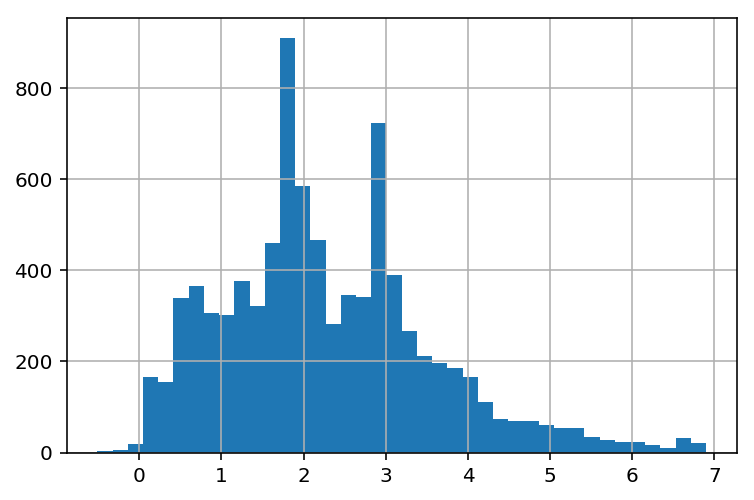

In [4]:
# Distribution du log des prix
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
train['logprix'] = train['prix'].apply(np.log)
train['logprix'].hist(bins=40)

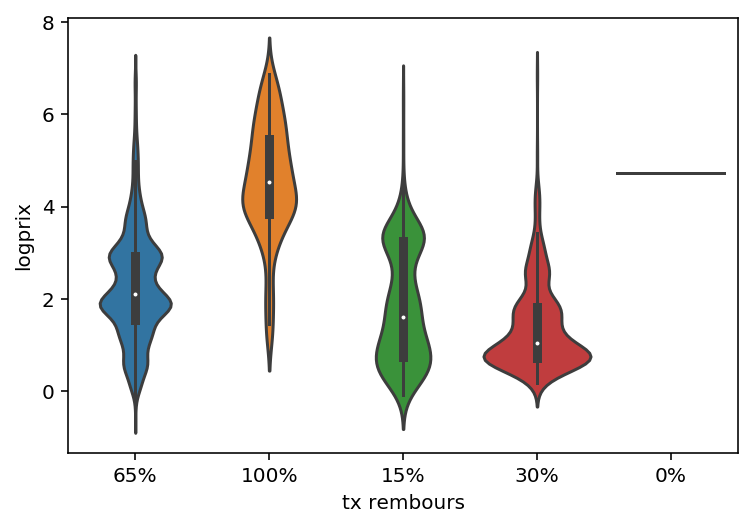

In [5]:
# Influence sur les prix de la feature "tx rembours"
sns.violinplot(y="logprix", x="tx rembours", data=train);

In [7]:
train

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix,logprix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83,1.040277
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30,2.660260
2,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,2000,1996,Procédure nationale,MYLAN SAS,CHLORHYDRATE DE DILTIAZEM,5.66,1.733424
3,30 sachet(s)-dose(s) papier aluminium complexe...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,Autorisation active,2005,2004,Procédure nationale,SANOFI AVENTIS FRANCE,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",24.27,3.189241
4,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,Autorisation active,2015,2010,Procédure nationale,TEVA SANTE,LÉTROZOLE,59.94,4.093344
5,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,100%,comprimé,orale,Autorisation active,2001,2000,Procédure nationale,EG LABO - LABORATOIRES EUROGENERICS,FLUTAMIDE,27.17,3.302113
6,flacon(s) polyéthylène haute densité (PEHD) de...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,100,0.0,Présentation active,Déclaration de commercialisation,oui,100%,capsule molle,orale,Autorisation active,2015,2001,Procédure centralisée,EISAI (ROYAUME-UNI),BEXAROTÈNE,877.83,6.777453
7,plaquette(s) thermoformée(s) PVC polyéthylène ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé,orale,Autorisation active,2006,2006,Procédure de reconnaissance mutuelle,SANDOZ,GLIMÉPIRIDE,6.58,1.884035
8,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,oui,65%,comprimé sécable,orale,Autorisation active,2013,2002,Procédure nationale,ARROW GENERIQUES,MALÉATE D'ÉNALAPRIL,18.63,2.924773
9,plaquette(s) polyamide aluminium PVC de 10 com...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,non,65%,comprimé pelliculé,orale,Autorisation active,2015,2012,Procédure nationale,ARROW GENERIQUES,"CEFPODOXIME PROXÉTIL, CEFPODOXIME",6.13,1.813195


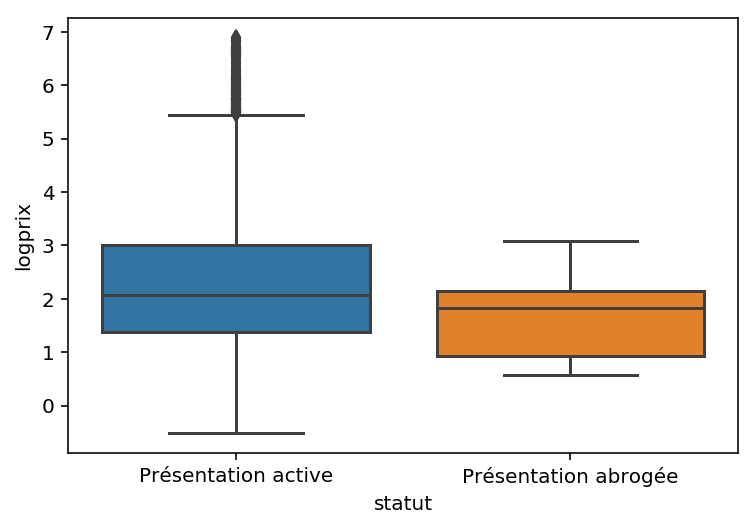

In [6]:
# Influence sur les prix de la feature "statut"
sns.boxplot(y="logprix", x="statut", data=train)

# Preparation des donnees

In [7]:
# On rassemble pour le feature engineering
df = pd.concat([train,test])
train.head(2)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix,logprix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83,1.040277
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30,2.660260


In [8]:
# Creation 3 features : sum libelle, sum nb, nb+libelle
list_nb_libelle = [col for col in df.columns if col.startswith('libelle') and not col.endswith('libelle')]
df.loc[:,'nb_libelle'] = df[list_nb_libelle].sum(axis=1)

list_nb_nb = [col for col in df.columns if col.startswith('nb') and not col.endswith('libelle')]
df.loc[:,'nb_nb'] = df[list_nb_nb].sum(axis=1)

df.loc[:,'nb_libelle_et_nb'] = df.nb_nb + df.nb_libelle

In [9]:
# On cree une feature qui est le nombre de lettre de substances
df['len_charact_substances'] = df.substances.map(len)
df['nb_substances'] = df.substances.map(lambda x:len(x.split(', ')))

In [10]:
# TF IDF sur substances
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0, stop_words = 'english')
corp = df.substances
tfidf_matrix =  tf.fit_transform(corp)
print tfidf_matrix.shape    # on regarde si on peut traiter la matrice ou si on doit SVD
dense = pd.DataFrame(data=tfidf_matrix.todense(), columns=tf.get_feature_names())
list_feature_name = (df.columns | dense.columns).tolist()
df_dense = pd.DataFrame(data=np.concatenate((np.array(df),np.array(dense)), axis=1), columns=list_feature_name)
df_dense.head(2)

(12235, 1442)


,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,id,libelle,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,libelle_gelule,libelle_pilulier,libelle_plaquette,libelle_poche,libelle_sachet,libelle_seringue,libelle_stylo,libelle_tube,logprix,nb_ampoule,nb_capsule,nb_comprime,nb_film,nb_flacon,nb_gelule,nb_ml,nb_pilulier,nb_plaquette,nb_poche,nb_sachet,nb_seringue,nb_stylo,nb_tube,prix,statut,statut admin,substances,titulaires,tx rembours,type proc,voies admin,nb_libelle,nb_nb,nb_libelle_et_nb,len_charact_substances,nb_substances,10a,11,11a,12f,1331,135,13c,14,158,15b,16,165,175,179a,17f,18,181,18c,197,19a,19f,1a,1b,20,2009,2010,2011,2013,2014,22f,23f,27,2a,2b,3073,326f,3350,33f,361,39,4000,4385,55,6a,6b,74xp,7f,88,940,9715293,974p,980,9n,9v,ab,abacavir,abatacept,abeille,acamprosate,acarbose,aciclovir,acide,acides,acitrétine,actif,activé,acébutolol,acéclofénac,acénocoumarol,acéponate,acétate,acétazolamide,acétique,acétonide,acétyl,acétylaté,acétylcystéine,acétylleucine,acétylsalicylate,acétylsalicylique,adalimumab,adapalène,adjuvant,adrénaline,adsorbé,adsorbée,adéfovir,aflibercept,afrique,aggloméré,agomélatine,alanine,albendazole,alcool,alendronate,alendronique,alfa,alfacalcidol,alfuzosine,alginate,alginique,alimémazine,aliskirène,alitrétinoïne,alizapride,allergénique,allopurinol,alminoprofène,almotriptan,alpha,alprazolam,alprostadil,altizide,altrétamine,aluminium,alvérine,amantadine,ambénonium,amidotrizoate,amiloride,aminolévulinate,aminosalicylate,amiodarone,amisulpride,amitriptyline,amlodipine,ammonium,amorolfine,amoxapine,amoxicilline,amphotéricine,ampicilline,anagrélide,anakinra,analogue,anastrozole,anatoxine,androstanolone,anhydre,anti,antigène,antigènes,antimoine,antimoniate,anétholtrithione,apixaban,apomorphine,apraclonidine,aprépitant,argentique,arginine,aripiprazole,artéméther,arténimol,ascorbate,ascorbique,asparaginase,asparte,aspartique,aspartyl,atazanavir,atorvastatine,atovaquone,atropine,attapulgite,attenué,atténué,atténuée,aténolol,australia,avec,axitinib,axétil,azathioprine,azithromycine,aztréonam,azélastine,bacilles,bacitracine,baclofène,bactérie,bambutérol,bamifylline,bartram,baryum,base,bcg,bendrofluméthiazide,bensérazide,benzalkonium,benzathine,benzoate,benzoyle,benzyle,benzylique,benzylpénicilline,benzylthiouracile,bexarotène,bicalutamide,bicarbonate,bifonazole,bilastine,bimatoprost,biogénétique,biotine,biphasique,bipéridène,bismuth,bisoprolol,bléomycine,borax,bordetella,borique,bosutinib,bovis,brimonidine,brinzolamide,brisbane,bromazépam,bromfénac,bromhydrate,bromocriptine,bromphéniramine,bromure,budésonide,bumétanide,buprénorphine,buspirone,busulfan,buséréline,butylamine,butylbromure,butyrate,bx,béclométasone,béclométhasone,bénazépril,bésilate,bétacyclodextrine,bétahistine,bétamethasone,bétaméthasone,bétaxolol,bézafibrate,bêta,c11,cabergoline,cade,caféine,calcifédiol,calcipotriol,calcique,calcitonine,calcitriol,calcium,california,calmette,camphosulfonate,candésartan,caproate,captopril,capécitabine,carbamazépine,carbidopa,carbimazole,carbomère,carbonate,carmellose,carpipramine,cartéolol,carvédilol,casei,cefpodoxime,ceftazidime,ceftriaxone,ceféfadroxil,cerevisiae,certolizumab,charbon,chaîne,chlorambucil,chlore,chlorhexidine,chlorhydrate,chlorhydrique,chlormadinone,chlorobutanol,chlorocrésol,chloroquine,chlorpromazine,chlortalidone,chlorure,cholécalciférol,choriogonadotropine,chorionique,christchurch,chrome,chromique,ci,cibenzoline,ciclopirox,ciclosporine,ciclésonide,ciclétanine,cilastatine,cilazapril,cilexétil,cimétidine,cinacalcet,cinchonidine,cinchonine,ciprofibrate,ciprofloxacine,cire,citalopram,citrate,citrique,cladribine,clarithromycine,clavulanate,clavulanique,clindamycine,clobazam,clobétasol,clodronate,clomifène,clomipramine,clonazépam,clonidine,clopamide,clopidogrel,clorazépate,clotiazépam,cloxacilline,clozapine,cobalt,cobicistat,cocarboxylase,codesséchés,codéine,colchicine,colestyramine,colistiméthate,colloïdale,colécalciférol,complexe,concentrat,co

### Dummification

In [11]:
# titulaire reste a traiter
feat_drop = ['id', 'libelle', 'prix', 'substances', 'titulaires']
# pour les features binaires (ET CATEGORIELLES ORDINALES qui sont traitees de la meme facon !)
feat_bin = ['agrement col', 'statut admin','tx rembours']
feat_cat = ['statut', 'etat commerc', 'voies admin', 'type proc', 'forme pharma']
feat_num = [col for col in df_dense.columns if col not in feat_drop and col not in feat_cat and col not in feat_bin]
df_dense = df_dense.drop(feat_drop, 1)

In [12]:
# pour les featues categorielles (dummification)
X_dummies = pd.DataFrame()
X_dummies[feat_cat] = df_dense[feat_cat]
X_dummies = pd.get_dummies(X_dummies)

In [13]:
# pour les features binaires (ET CATEGORIELLES ORDINALES)
X_dummies[feat_bin] = df_dense[feat_bin]
for c in feat_bin:
    le = LabelEncoder()
    le.fit(X_dummies[c])
    X_dummies[c] = le.transform(df[c])

In [14]:
# les features continues
X_dummies[feat_num] = df_dense[feat_num].convert_objects(convert_numeric=True)

/Users/samuelrochette/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


### On separe a nouveau train et test

In [15]:
df_train = X_dummies[:train.shape[0]]
df_test = X_dummies[(X_dummies.shape[0] - test.shape[0]):]

In [16]:
target_train = df_train.logprix
df_train = df_train.drop('logprix', inplace=False, axis=1)

target_test = df_test.logprix
df_test = df_test.drop('logprix', inplace=False, axis=1)

# Creation d'un modele

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [20]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Variables importantes

In [17]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train, target_train, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100,random_state=42, n_jobs=8)
rf.fit(X_train, y_train)

feat_imp = rf.feature_importances_
df_feat = pd.DataFrame(data=feat_imp, index=X_train.columns)

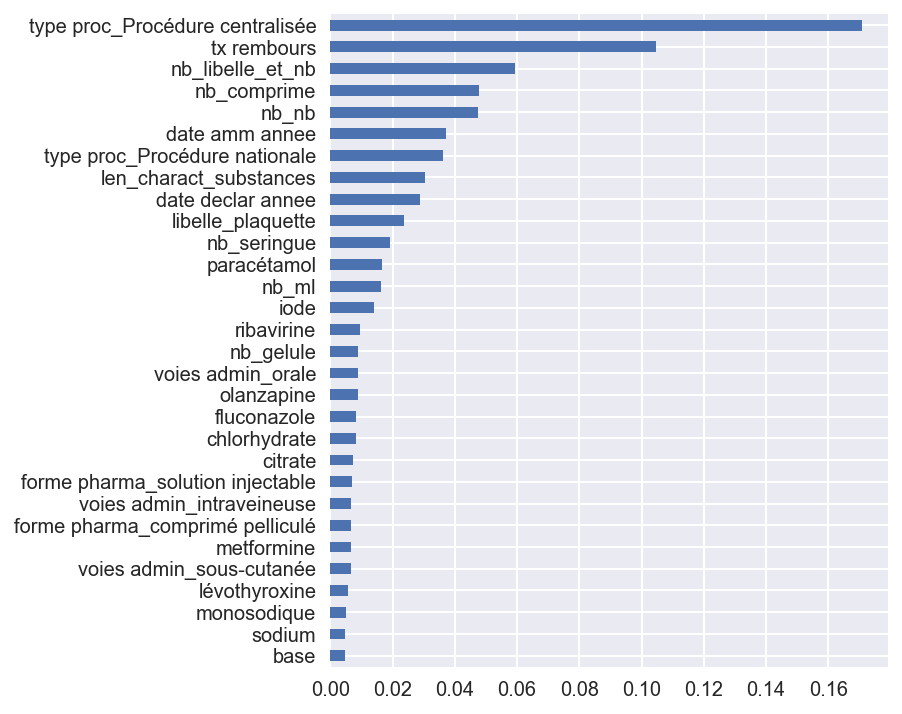

In [18]:
plt.figure(figsize=(5,6))
feat = df_feat[0].sort_values(ascending=False)
ax = feat.iloc[:30].plot(kind="barh")
ax.invert_yaxis()

### Cross validation

In [21]:
# SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import time

df_train1 = df_train.replace(np.inf, np.nan)
df_train1 = df_train.replace(np.nan, 0)

t0 = time.time()
# Reduce dimensions using Singular Value Decomposition
svd = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=5, random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_dummies_transformed_svd = pd.DataFrame(lsa.fit_transform(df_train1))
print("SVD in %fs" % (time.time() - t0))
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance %f" % (explained_variance))

# modele Extra Trees
from sklearn.ensemble import ExtraTreesRegressor
err = 0
NBROUND = 5
for train_index, test_index in KFold(X_dummies_transformed_svd.shape[0], n_folds=NBROUND, random_state=42):
    y = target_train
    X = X_dummies_transformed_svd
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    etr = ExtraTreesRegressor(n_estimators=1000, criterion='mse', max_depth=7,
                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                              max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                              n_jobs=8, random_state=42, verbose=0, warm_start=False)
    etr.fit(X_train, y_train)
    pred = etr.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print mape_error(np.exp(y_test), np.exp(pred))
print "*** MAPE Error : ", err / NBROUND

SVD in 4.373332s
Explained variance 0.967895


KeyboardInterrupt: 

In [21]:
# modele XGB
import xgboost as xgb
for i in range(5):
    err = 0
    NBROUND = 3
    for train_index, test_index in KFold(df_train.shape[0], n_folds=NBROUND, random_state=42):
        y = target_train
        X = df_train
        X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = xgb.XGBRegressor(max_depth=6, n_estimators=200, learning_rate=0.06, 
                               nthread=8, subsample=0.75, colsample_bytree=0.75, seed=42)
        clf.fit(X_train, y_train, early_stopping_rounds=200,
                eval_metric='map', eval_set=[(X_test, y_test)], verbose=False)
        pred = clf.predict(X_test)
        # ne pas oublier de reprendre l'exponentielle de la prédiction
        err += mape_error(np.exp(y_test), np.exp(pred))
        print mape_error(np.exp(y_test), np.exp(pred))
    print "*** MAPE Error : ", err / NBROUND

48.4782892364
48.6237084858
48.43961544
*** MAPE Error :  48.5138710541
48.4782892364
48.6237084858
48.43961544
*** MAPE Error :  48.5138710541


KeyboardInterrupt: 

best MAPE Error :  33.4791820579

Cela veut dire notre modele predit les prix des medicaments avec environ 34% d’erreur en moyenne. Par exemple, si un medicament vaut reellement 10€, notre prediction sera de 13.4€ (ou 6.6€).

# Calcul des predictions et soumission

In [23]:
clf.best_iteration

1657

In [24]:
clf = xgb.XGBRegressor(max_depth=7, n_estimators=1657, learning_rate=0.05, 
                       nthread=8, subsample=0.8, colsample_bytree=0.6,
                       min_child_weight = 1, seed=42)
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
clf.fit(df_train, target_train)

predictions = np.exp(clf.predict(df_test))

pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv', header=['prix'], sep = ';')

Vous etes maintenant pret ? Faites votre premiere soumission en uplodant le fichier `soumission.csv` sur [Datascience.net](http://www.datascience.net)